In [5]:
!pip install keras-tuner -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


# Створення функції для побудови моделі

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt
import numpy as np
import matplotlib.pyplot as plt

# Завантажимо датасет Fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Нормалізація даних
train_images = train_images / 255.0
test_images = test_images / 255.0

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=64,
                                            max_value=512,
                                            step=64),
                               activation='relu'))
        model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i),
                                               min_value=0.0,
                                               max_value=0.5,
                                               step=0.1)))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate',
                                                           min_value=1e-4,
                                                           max_value=1e-2,
                                                           sampling='LOG')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


<ipython-input-6-25deae0001d4>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# Використання Keras Tuner для пошуку оптимальних гіперпараметрів

In [7]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Отримання найкращих гіперпараметрів
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')} with the following units and dropout rates for each layer:
""")
for i in range(best_hps.get('num_layers')):
    print(f"Layer {i+1}: {best_hps.get('units_' + str(i))} units, dropout rate {best_hps.get('dropout_' + str(i))}")
print(f"The optimal learning rate is {best_hps.get('learning_rate')}")


Trial 30 Complete [00h 02m 12s]
val_accuracy: 0.8869166374206543

Best val_accuracy So Far: 0.893833339214325
Total elapsed time: 00h 56m 15s

The hyperparameter search is complete. The optimal number of layers is 3 with the following units and dropout rates for each layer:

Layer 1: 512 units, dropout rate 0.1
Layer 2: 384 units, dropout rate 0.2
Layer 3: 448 units, dropout rate 0.2
The optimal learning rate is 0.0003219313170416267


# Навчання та оцінка моделі з найкращими гіперпараметрами

Epoch 1/50
375/375 [==============================] - 11s 27ms/step - loss: 0.6213 - accuracy: 0.7803 - val_loss: 0.4300 - val_accuracy: 0.8399
Epoch 2/50
375/375 [==============================] - 8s 22ms/step - loss: 0.4043 - accuracy: 0.8552 - val_loss: 0.3812 - val_accuracy: 0.8611
Epoch 3/50
375/375 [==============================] - 10s 26ms/step - loss: 0.3589 - accuracy: 0.8703 - val_loss: 0.3483 - val_accuracy: 0.8749
Epoch 4/50
375/375 [==============================] - 10s 26ms/step - loss: 0.3308 - accuracy: 0.8788 - val_loss: 0.3369 - val_accuracy: 0.8749
Epoch 5/50
375/375 [==============================] - 11s 29ms/step - loss: 0.3073 - accuracy: 0.8866 - val_loss: 0.3241 - val_accuracy: 0.8823
Epoch 6/50
375/375 [==============================] - 9s 23ms/step - loss: 0.2919 - accuracy: 0.8902 - val_loss: 0.3090 - val_accuracy: 0.8879
Epoch 7/50
375/375 [==============================] - 10s 27ms/step - loss: 0.2785 - accuracy: 0.8960 - val_loss: 0.3119 - val_accuracy: 0

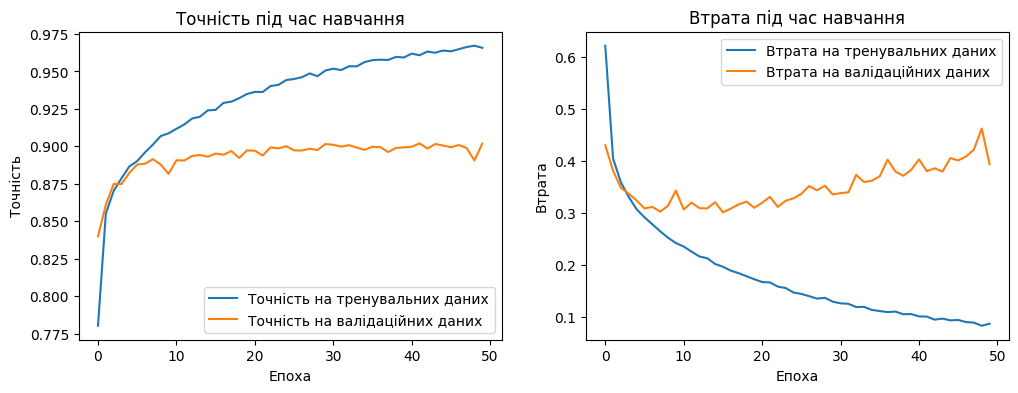

In [8]:
# Побудова моделі з найкращими гіперпараметрами
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_images, train_labels, epochs=50, batch_size=128, validation_split=0.2)

# Оцінка моделі
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nТочність на тестових даних:', test_acc)

# Відображення графіків навчання
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точність на тренувальних даних')
plt.plot(history.history['val_accuracy'], label='Точність на валідаційних даних')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend(loc='lower right')
plt.title('Точність під час навчання')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Втрата на тренувальних даних')
plt.plot(history.history['val_loss'], label='Втрата на валідаційних даних')
plt.xlabel('Епоха')
plt.ylabel('Втрата')
plt.legend(loc='upper right')
plt.title('Втрата під час навчання')

plt.show()


# Нвчання та оцінка моделі з найкращими гіперпараметрами №2

Epoch 1/50
375/375 [==============================] - 10s 23ms/step - loss: 0.6144 - accuracy: 0.7850 - val_loss: 0.4199 - val_accuracy: 0.8490
Epoch 2/50
375/375 [==============================] - 10s 26ms/step - loss: 0.3996 - accuracy: 0.8567 - val_loss: 0.3603 - val_accuracy: 0.8673
Epoch 3/50
375/375 [==============================] - 10s 26ms/step - loss: 0.3558 - accuracy: 0.8709 - val_loss: 0.3513 - val_accuracy: 0.8729
Epoch 4/50
375/375 [==============================] - 8s 22ms/step - loss: 0.3294 - accuracy: 0.8785 - val_loss: 0.3452 - val_accuracy: 0.8762
Epoch 5/50
375/375 [==============================] - 10s 26ms/step - loss: 0.3130 - accuracy: 0.8840 - val_loss: 0.3212 - val_accuracy: 0.8808
Epoch 6/50
375/375 [==============================] - 11s 29ms/step - loss: 0.2903 - accuracy: 0.8927 - val_loss: 0.3310 - val_accuracy: 0.8792
Epoch 7/50
375/375 [==============================] - 9s 25ms/step - loss: 0.2771 - accuracy: 0.8966 - val_loss: 0.3215 - val_accuracy: 0

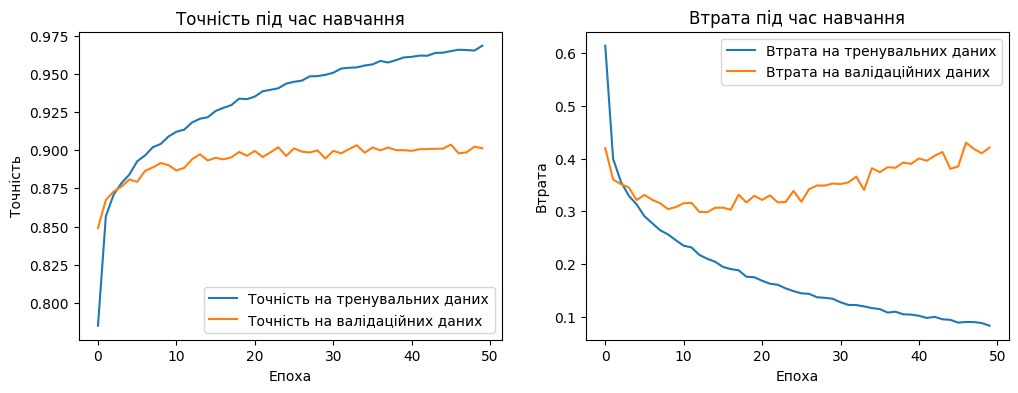

In [9]:
# Побудова моделі з оптимальними гіперпараметрами
model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(384, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(448, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

# Налаштування оптимізатора з оптимальним learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0003219313170416267)

# Компільовання моделі
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Навчання моделі
history = model.fit(train_images, train_labels, epochs=50, batch_size=128, validation_split=0.2)

# Оцінка моделі
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nТочність на тестових даних:', test_acc)

# Відображення графіків навчання
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точність на тренувальних даних')
plt.plot(history.history['val_accuracy'], label='Точність на валідаційних даних')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend(loc='lower right')
plt.title('Точність під час навчання')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Втрата на тренувальних даних')
plt.plot(history.history['val_loss'], label='Втрата на валідаційних даних')
plt.xlabel('Епоха')
plt.ylabel('Втрата')
plt.legend(loc='upper right')
plt.title('Втрата під час навчання')

plt.show()

In [10]:
accuracy_decimal = 0.8985000252723694
accuracy_percentage = accuracy_decimal * 100
print(f'Точність на тестових даних: {accuracy_percentage:.2f}%')


Точність на тестових даних: 89.85%



#На основі проведеної роботи та результатів, можна зробити такі висновки:

1. Підбір гіперпараметрів за допомогою Keras Tuner:

  - Використання Keras Tuner дозволило автоматизувати процес підбору оптимальних гіперпараметрів. Це зменшило кількість ручних спроб та помилок у налаштуванні моделі.
  - Найкращі знайдені гіперпараметри допомогли досягти значної точності, проте вона все ще не досягла бажаних 91%.
2. Результати моделі:

  - Найкраща досягнута точність на тестових даних становила 89.85%, що є досить високим результатом, але трохи нижче цільових 91%.
  - Це свідчить про те, що обрана архітектура та гіперпараметри вже досить оптимальні, але для досягнення вищої точності можливо потрібно внести додаткові зміни або вдосконалення.
3. Можливі покращення:

  - Збільшення кількості епох: Навчання моделі на більшій кількості епох може допомогти покращити точність.
  - Регуляризація: Використання більш складних методів регуляризації, таких як L2-регуляризація, може допомогти зменшити перенавчання.
  - Аугментація даних: Використання технік аугментації даних може допомогти покращити узагальнюючу здатність моделі.
  - Інші оптимізатори: Спробуйте використовувати інші оптимізатори, такі як RMSprop або Nadam.
4. Аналіз результатів:

  - Модель досягла значного прогресу з 88.66% до 89.85%, але це свідчить, що досягнення ще вищої точності може вимагати більш глибокого аналізу та модифікації.

## Отже, проведена робота показала, що модель може досягти високої точності, але для досягнення цільових 91% потрібно продовжити експерименти з гіперпараметрами, архітектурою моделі та іншими техніками машинного навчання.